# Libraries

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque
import random

In [2]:
from tensorflow.keras.models import Sequential  # To compose multiple layers
from tensorflow.keras.layers import Dense, Input  # Fully-Connected layer
from tensorflow.keras.layers import Activation  # Activation functions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import clone_model

# Hyperparameters

In [3]:
EPOCHS = 1000

epsilon = 1.0
EPSILON_REDUCE = 0.995  # is multiplied with epsilon each epoch to reduce it
ALPHA = 0.001 #NOT THE SAME AS ALPHA FROM Q-LEARNING FROM BEFORE!!
GAMMA = 0.95

# Environment setup

In [4]:
env = gym.make("LunarLander-v2")#, render_mode="human")
observation, info = env.reset(seed=42)

In [5]:
num_actions = env.action_space.n
num_observations = env.observation_space.shape[0]  # You can use this command to get the number of observations
print(f"There are {num_actions} possible actions and {num_observations} observations")

There are 4 possible actions and 8 observations


So our network needs to have an input dimension of 4 and an output dimension of 8.
In between we are free to chose.


# Setting up neural network

CHECK SHAPES

In [6]:
model = Sequential()

model.add(Input(shape=(num_observations,)))

model.add(Dense(16))
model.add(Activation('relu'))

model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(num_actions))
model.add(Activation('linear'))

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 820 (3.20 KB)

 Trainable params: 820 (3.20 KB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
target_model = clone_model(model)

# Setting up policy

In [8]:
def epsilon_greedy_action_selection(model, epsilon, observation):
    if np.random.random() > epsilon:
        observation = observation.reshape([1, 8]) 
        prediction = model.predict(observation, verbose=0)  # perform the prediction on the observation
        action = np.argmax(prediction)  # Chose the action with the higher value
    else:
        action = np.random.randint(0, env.action_space.n)  # Else use random action
    return action

In [9]:
replay_buffer = deque(maxlen=20000)
update_target_model = 10

In [10]:
def replay(replay_buffer, batch_size, model, target_model):
    
    # As long as the buffer has not enough elements we do nothing
    if len(replay_buffer) < batch_size: 
        return
    
    # Take a random sample from the buffer with size batch_size
    samples = random.sample(replay_buffer, batch_size)  
    
    # to store the targets predicted by the target network for training
    target_batch = []  
    
    # Efficient way to handle the sample by using the zip functionality
    zipped_samples = list(zip(*samples))  
    states, actions, rewards, new_states, terminateds, truncateds = zipped_samples  
    
    # Predict targets for all states from the sample
    targets = target_model.predict(np.array(states), verbose=0)

    # Predict Q-Values for all new states from the sample
    q_values = model.predict(np.array(new_states), verbose=0)
    
    # Now we loop over all predicted values to compute the actual targets
    for i in range(batch_size):  
        
        # Take the maximum Q-Value for each sample
        q_value = max(q_values[i])
        
        # Store the ith target in order to update it according to the formula
        target = targets[i].copy() 
        if terminateds[i] or truncateds[i]:
            target[actions[i]] = rewards[i]
        else:
            target[actions[i]] = rewards[i] + q_value * GAMMA
        target_batch.append(target)

    # Fit the model based on the states and the updated targets for 1 epoch
    model.fit(np.array(states), np.array(target_batch), epochs=1, verbose=0)

In [11]:
def update_model_handler(epoch, update_target_model, model, target_model):
    if epoch > 0 and epoch % update_target_model == 0:
        target_model.set_weights(model.get_weights())

# Training the model

In [12]:
model.compile(loss='mse', optimizer=Adam(learning_rate=ALPHA))

In [13]:
epochs = []
rewards = []
rewards_rm = []
successes = []
successes_rm = []

In [14]:
best_so_far = 0
for epoch in tqdm(range(EPOCHS)):
    observation,info = env.reset()  # Get inital state

    terminated = False  
    truncated = False
    
    points = 0
    epochs.append(epoch)
    while not terminated and not truncated:  # as long current run is active
        
        # Select action acc. to strategy
        action = epsilon_greedy_action_selection(model, epsilon, observation)
        
        # Perform action and get next state
        next_observation, reward, terminated, truncated, info = env.step(action)  
        replay_buffer.append((observation, action, reward, next_observation, terminated, truncated))  # Update the replay buffer
        observation = next_observation  # update the observation
        points+=1

        # Most important step! Training the model by replaying
        replay(replay_buffer, 32, model, target_model)

    epsilon *= EPSILON_REDUCE  # Reduce epsilon
    rewards.append(points)  # log overall achieved points for the current epoch
    rewards_rm.append(np.mean(rewards[-300:]))  # Compute running mean points over the last 30 epochs
    successes.append(points>=200) # Has the agent scored at least 200 points?
    successes_rm.append(np.mean(successes[-300:]))
    
    # Check if we need to update the target model
    update_model_handler(epoch, update_target_model, model, target_model)
    
    if points > best_so_far:
        best_so_far = points
    if epoch %25 == 0:
        print(f"{epoch}: Points reached: {points} - epsilon: {epsilon} - Best: {best_so_far}")

  0%|          | 1/1000 [00:03<58:38,  3.52s/it]

0: Points reached: 96 - epsilon: 0.995 - Best: 96


  3%|▎         | 26/1000 [02:02<1:15:03,  4.62s/it]

25: Points reached: 73 - epsilon: 0.8778091417340573 - Best: 146


  5%|▌         | 51/1000 [04:16<1:39:33,  6.29s/it]

50: Points reached: 136 - epsilon: 0.7744209942832988 - Best: 153


  8%|▊         | 76/1000 [07:04<1:38:11,  6.38s/it]

75: Points reached: 85 - epsilon: 0.6832098777212641 - Best: 219


 10%|█         | 101/1000 [11:05<2:32:21, 10.17s/it]

100: Points reached: 179 - epsilon: 0.6027415843082742 - Best: 1000


 13%|█▎        | 126/1000 [17:37<5:14:58, 21.62s/it]

125: Points reached: 189 - epsilon: 0.531750826943791 - Best: 1000


 15%|█▌        | 151/1000 [23:27<3:00:17, 12.74s/it]

150: Points reached: 239 - epsilon: 0.46912134373457726 - Best: 1000


 18%|█▊        | 176/1000 [32:21<4:55:58, 21.55s/it] 

175: Points reached: 548 - epsilon: 0.41386834584198684 - Best: 1000


 20%|██        | 201/1000 [41:08<4:43:02, 21.25s/it]

200: Points reached: 242 - epsilon: 0.36512303261753626 - Best: 1000


 23%|██▎       | 226/1000 [51:02<4:29:25, 20.89s/it]

225: Points reached: 109 - epsilon: 0.322118930542046 - Best: 1000


 25%|██▌       | 251/1000 [59:24<5:38:49, 27.14s/it]

250: Points reached: 149 - epsilon: 0.28417984116121187 - Best: 1000


 28%|██▊       | 276/1000 [1:08:09<2:28:42, 12.32s/it]

275: Points reached: 129 - epsilon: 0.2507092085103961 - Best: 1000


 30%|███       | 301/1000 [1:19:17<4:43:42, 24.35s/it]

300: Points reached: 287 - epsilon: 0.2211807388415433 - Best: 1000


 33%|███▎      | 326/1000 [1:28:55<4:25:45, 23.66s/it]

325: Points reached: 389 - epsilon: 0.19513012515638165 - Best: 1000


 35%|███▌      | 351/1000 [1:39:56<4:29:28, 24.91s/it]

350: Points reached: 202 - epsilon: 0.17214774642209296 - Best: 1000


 38%|███▊      | 376/1000 [1:51:30<5:12:41, 30.07s/it]

375: Points reached: 364 - epsilon: 0.1518722266715875 - Best: 1000


 40%|████      | 401/1000 [2:04:20<7:09:20, 43.01s/it]

400: Points reached: 662 - epsilon: 0.13398475271138335 - Best: 1000


 43%|████▎     | 426/1000 [2:18:24<4:26:24, 27.85s/it]

425: Points reached: 89 - epsilon: 0.11820406108847166 - Best: 1000


 45%|████▌     | 451/1000 [2:38:07<4:42:12, 30.84s/it]

450: Points reached: 307 - epsilon: 0.1042820154910064 - Best: 1000


 48%|████▊     | 476/1000 [2:58:09<8:24:58, 57.82s/it]

475: Points reached: 1000 - epsilon: 0.09199970504166631 - Best: 1000


 50%|█████     | 501/1000 [3:15:05<7:04:50, 51.08s/it]

500: Points reached: 1000 - epsilon: 0.0811640021330769 - Best: 1000


 53%|█████▎    | 526/1000 [3:33:32<5:36:46, 42.63s/it]

525: Points reached: 1000 - epsilon: 0.0716045256805401 - Best: 1000


 55%|█████▌    | 551/1000 [3:55:19<7:17:42, 58.49s/it]

550: Points reached: 1000 - epsilon: 0.06317096204211972 - Best: 1000


 58%|█████▊    | 576/1000 [4:17:25<5:29:05, 46.57s/it]

575: Points reached: 1000 - epsilon: 0.05573070148010834 - Best: 1000


 60%|██████    | 601/1000 [4:42:11<7:35:47, 68.54s/it]

600: Points reached: 1000 - epsilon: 0.04916675299948831 - Best: 1000


 63%|██████▎   | 626/1000 [5:10:06<6:55:36, 66.68s/it]

625: Points reached: 1000 - epsilon: 0.043375904776212296 - Best: 1000


 65%|██████▌   | 651/1000 [5:38:30<6:37:39, 68.36s/it]

650: Points reached: 1000 - epsilon: 0.03826710124979409 - Best: 1000


 68%|██████▊   | 676/1000 [6:06:58<6:09:17, 68.39s/it]

675: Points reached: 1000 - epsilon: 0.033760011361539714 - Best: 1000


 70%|███████   | 701/1000 [6:32:35<5:20:27, 64.30s/it]

700: Points reached: 1000 - epsilon: 0.029783765425331846 - Best: 1000


 73%|███████▎  | 726/1000 [7:00:15<5:15:08, 69.01s/it]

725: Points reached: 1000 - epsilon: 0.026275840769466357 - Best: 1000


 75%|███████▌  | 751/1000 [7:26:04<4:44:26, 68.54s/it]

750: Points reached: 1000 - epsilon: 0.023181078627322618 - Best: 1000


 78%|███████▊  | 776/1000 [7:50:57<3:07:23, 50.20s/it]

775: Points reached: 554 - epsilon: 0.020450816818411825 - Best: 1000


 80%|████████  | 801/1000 [8:13:41<2:50:01, 51.26s/it]

800: Points reached: 775 - epsilon: 0.018042124582040707 - Best: 1000


 83%|████████▎ | 826/1000 [8:31:22<2:09:40, 44.72s/it]

825: Points reached: 772 - epsilon: 0.015917127532080494 - Best: 1000


 85%|████████▌ | 851/1000 [8:51:58<2:15:50, 54.70s/it]

850: Points reached: 975 - epsilon: 0.014042412118399107 - Best: 1000


 88%|████████▊ | 876/1000 [9:15:40<2:09:22, 62.60s/it]

875: Points reached: 1000 - epsilon: 0.012388500230681249 - Best: 1000


 90%|█████████ | 901/1000 [9:37:46<1:12:44, 44.08s/it]

900: Points reached: 478 - epsilon: 0.010929385683282892 - Best: 1000


 93%|█████████▎| 926/1000 [9:59:59<1:08:44, 55.74s/it]

925: Points reached: 989 - epsilon: 0.009642125292786984 - Best: 1000


 95%|█████████▌| 951/1000 [10:21:34<43:27, 53.22s/it]  

950: Points reached: 664 - epsilon: 0.008506478118345316 - Best: 1000


 98%|█████████▊| 976/1000 [10:42:08<16:50, 42.12s/it]

975: Points reached: 602 - epsilon: 0.007504587192205264 - Best: 1000


100%|██████████| 1000/1000 [11:03:47<00:00, 39.83s/it]


## Saving model weights

In [15]:
model.save_weights('out/dqn_model_weights.weights.h5')

# Visualizing results

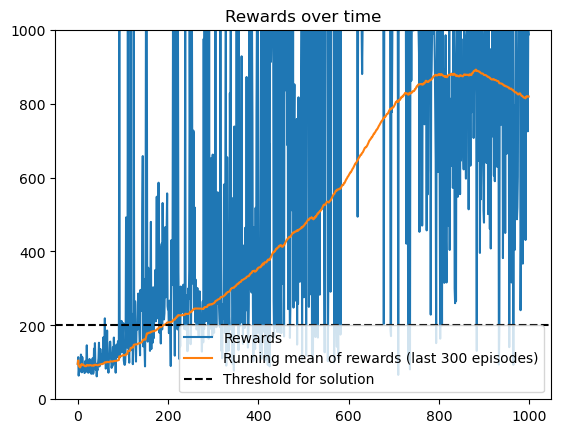

In [16]:
plt.plot(epochs, rewards, label='Rewards')
plt.plot(epochs, rewards_rm, label='Running mean of rewards (last 300 episodes)')
plt.title('Rewards over time')
plt.axhline(200, linestyle='dashed', color='black', label='Threshold for solution')
plt.ylim(0,1000)
plt.legend()
plt.savefig('out/DQN approach.png')
plt.show()

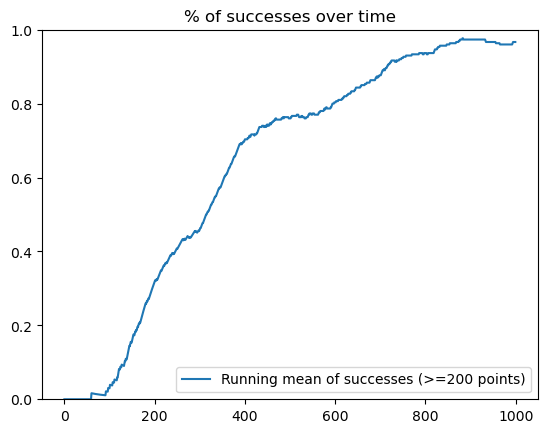

In [17]:
plt.plot(epochs, successes_rm, label='Running mean of successes (>=200 points)')
plt.title('% of successes over time')
plt.ylim(0,1)
plt.legend()
plt.savefig('out/DQN approach - successes.png')
plt.show()